# Forecasting and Portfolio Optimization

The purpose of this notebook is to document my first venture into time series analysis and portfolio optimization.
I will be working with financial data that is stored on my local machine. In future projects, I hope to work with 
APIs to pull such information and more.

In [3]:
# Uncomment below when working outside of home device
data_dir = r'C:\Users\329982789\Desktop\ML for Trading\ML4T_2018Spring\ML4T_2018Spring\data'

# Uncomment below when working at home device
#data_dir = r'C:\Users\jc1\Desktop\ML4T_2018Spring\ML4T_2018Spring\data'

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from scipy import optimize as opt
from statsmodels.tsa.stattools import adfuller 

In [4]:
def symbol_to_path(symbol, base_dir=data_dir):
    """Return CSV file path given ticker symbol."""
    if base_dir is None:
        base_dir = os.environ.get("MARKET_DATA_DIR", '../data/')
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates, addSPY=True, colname = 'Adj Close'):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if addSPY and 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols = ['SPY'] + symbols

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', colname], na_values=['nan'])
        df_temp = df_temp.rename(columns={colname: symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])
    return df
syms=['GOOG','AAPL','GLD','XOM']
sd=dt.datetime(2008,1,1)
ed=dt.datetime(2012,1,30)
dates = pd.date_range(sd, ed)
prices_all = get_data(syms, dates)  # automatically adds SPY
prices = prices_all[syms]  # only portfolio symbols
prices_SPY = prices_all['SPY']  # only SPY, for comparison later
#training_index = [:'2012-01-01']  <-- Not working, will fix later
#testing_index = ['2012-01-01':]   <-- Not working, will fix later
# normalizing values
prices_norm = prices/prices.iloc[0]
SPY_norm = prices_SPY/prices_SPY.iloc[0]
# filling in nan values in data
prices_norm.fillna(method='ffill',inplace=True) 
#prices_norm.fillna(method='bfill', inplace=True)



The cell below performs an Augmented Dickey-Fuller test to determine if the stock prices is a stationary time series or not.
An Augmented Dickey-Fuller test tests a time series against the null hypothesis
that there is a unit root contained in it.
If the p_value is large (>0.05), it is likely that there is a unit root and thus the series is not stationary
Otherwise, it is likely that the series is stationary.

Want more information about what I just told you?

Check out more about:
[The Null Hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis "Null Hypothesis")
[The Augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test "Augmented Dickey-Fuller Test")
[Unit Roots](https://en.wikipedia.org/wiki/Unit_root "Unit Root")


In [5]:
for sym in syms:
    print('Asset: ', sym)
    adf_df = adfuller(prices_norm[sym])
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, '\n')

# If you run this cell, you will see that the asset prices in this portfolio are not stationary time series
# since the p-values are much greater than 0.05, also notice has that the critical values are greater than the test statistic

Asset:  GOOG
test statistic            -2.335628
p-value                    0.160735
# of lags                  0.000000
# of observations       1027.000000
Critical Value (1%)       -3.436733
Critical Value (5%)       -2.864358
Critical Value (10%)      -2.568271
dtype: float64 

Asset:  AAPL
test statistic             0.937717
p-value                    0.993563
# of lags                  7.000000
# of observations       1020.000000
Critical Value (1%)       -3.436777
Critical Value (5%)       -2.864378
Critical Value (10%)      -2.568281
dtype: float64 

Asset:  GLD
test statistic            -0.241608
p-value                    0.933377
# of lags                  0.000000
# of observations       1027.000000
Critical Value (1%)       -3.436733
Critical Value (5%)       -2.864358
Critical Value (10%)      -2.568271
dtype: float64 

Asset:  XOM
test statistic            -1.673775
p-value                    0.444673
# of lags                  9.000000
# of observations       1018.000000

In [6]:
def turn_stationary(ts):
    # this function takes a time series (ts) as input and outputs a tuple containing the order of differencing
    # and a stationary version of ts
    # If ts is already stationary it returns a tuple with order of differencing 0 and the unmodified ts
    adf_df = adfuller(ts)
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    p_val = dfoutput.loc['p-value']
    # fills nan values
    differencing_order = 0
    iter = 0
    while p_val > 0.05:
        # fills nan values
        ts = ts.diff()
        ts.fillna(method='ffill', inplace=True)
        ts.fillna(method='bfill', inplace=True)
        adf_df = adfuller(ts)
        dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
        p_val = dfoutput.loc['p-value']
        differencing_order += 1
    lags = adf_df[2]
    observations = adf_df[3]
    return (differencing_order, lags, observations, ts)
    

Asset: AAPL
test statistic         -1.299256e+01
p-value                 2.792730e-24
# of lags               6.000000e+00
# of observations       1.021000e+03
Critical Value (1%)    -3.436771e+00
Critical Value (5%)    -2.864375e+00
Critical Value (10%)   -2.568279e+00
dtype: float64 



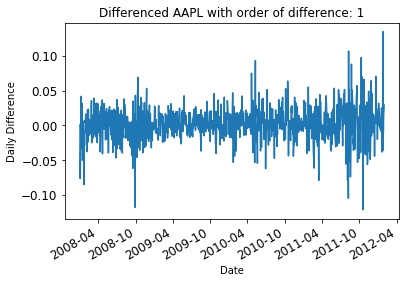

df head: 
 2008-01-02    0.000464
2008-01-03    0.000464
2008-01-04   -0.076388
2008-01-07   -0.012370
2008-01-08   -0.032782
Name: AAPL, dtype: float64 

df tail: 
 2012-01-24   -0.035926
2012-01-25    0.134735
2012-01-26   -0.010412
2012-01-27    0.013608
2012-01-30    0.029380
Name: AAPL, dtype: float64 



In [7]:
# testing the turn_stationary function to differenced series and order of difference for the stock AAPL (Apple Corp.)

result = turn_stationary(prices_norm['AAPL'])
print('Asset: AAPL')
asset = result[3]
diff = result[0]
lags = result[1]
obs = result[2]
adf_df = adfuller(asset)
dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput, '\n')

title = 'Differenced AAPL with order of difference: ' + str(result[0])
ax = asset.plot(title=title, fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Difference')
plt.show()
print('df head: \n', asset.head(), '\n')
print('df tail: \n', asset.tail(), '\n')



In [8]:
# this cell print the order of difference for each column
stationary_assets = pd.DataFrame(index=dates)
stationary_assets.index.name = 'Date'

diff_orders = np.array([])
lags = np.array([])
observations = np.array([])

for sym in syms:
    tup = turn_stationary(prices_norm[sym])
    diff_order = tup[0]
    lag = tup[1]
    observation = tup[2]
    diff_orders = np.append(diff_orders,diff_order)
    lags = np.append(lags,lag)
    observations = np.append(observations, observation)
details = [diff_orders, lags, observations]

print(diff_orders)
print(lags)
print(observations)
details_df = pd.DataFrame([diff_orders, lags, observations])
details_df.columns = syms
print(details_df)

[1. 1. 1. 1.]
[0. 6. 0. 8.]
[1027. 1021. 1027. 1019.]
     GOOG    AAPL     GLD     XOM
0     1.0     1.0     1.0     1.0
1     0.0     6.0     0.0     8.0
2  1027.0  1021.0  1027.0  1019.0


In [9]:
# since each stationary series' order of difference is 1, I simply apply the 
# pd.diff() function to a copy of the original DataFrame prices_norm
stationary_df = prices_norm.copy()
stationary_df = stationary_df.diff()
stationary_df.fillna(method="ffill", inplace=True)
stationary_df.fillna(method="bfill", inplace=True)
print('df head: \n', stationary_df.head(), '\n')
print('df tail: \n', stationary_df.tail(), '\n')


df head: 
                 GOOG      AAPL       GLD       XOM
2008-01-02  0.000204  0.000464  0.008367  0.003467
2008-01-03  0.000204  0.000464  0.008367  0.003467
2008-01-04 -0.041346 -0.076388 -0.005185 -0.018769
2008-01-07 -0.011311 -0.012370 -0.004242 -0.009085
2008-01-08 -0.025643 -0.032782  0.023686 -0.012552 

df tail: 
                 GOOG      AAPL       GLD       XOM
2012-01-24 -0.006699 -0.035926 -0.013552 -0.003347
2012-01-25 -0.016696  0.134735  0.051968  0.000478
2012-01-26 -0.002029 -0.010412  0.010016 -0.005380
2012-01-27  0.017338  0.013608  0.020033 -0.010998
2012-01-30 -0.003342  0.029380 -0.011077 -0.003945 



The cell below performs an Augmented Dickey-Fuller test to determine if each column of stock prices
is a stationary time series or not.
As stated earlier, an Augmented Dickey-Fuller test tests a time series against the null hypothesis that there is a unit root contained in it.

If the p_value is large (>0.05), it is likely that there is a unit root and thus the series is not stationary
Otherwise, it is likely that the series is stationary   

It will also plot the differenced series for each stock.

Asset:  GOOG
test statistic           -33.219908
p-value                    0.000000
# of lags                  0.000000
# of observations       1027.000000
Critical Value (1%)       -3.436733
Critical Value (5%)       -2.864358
Critical Value (10%)      -2.568271
dtype: float64 



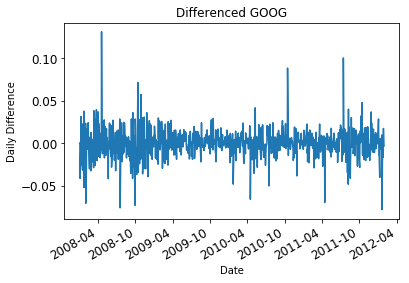

Asset:  AAPL
test statistic         -1.299256e+01
p-value                 2.792730e-24
# of lags               6.000000e+00
# of observations       1.021000e+03
Critical Value (1%)    -3.436771e+00
Critical Value (5%)    -2.864375e+00
Critical Value (10%)   -2.568279e+00
dtype: float64 



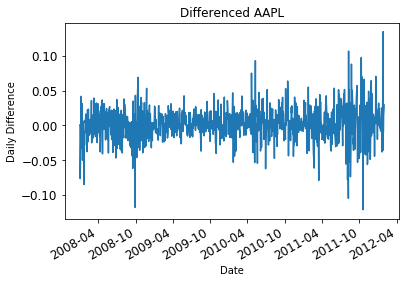

Asset:  GLD
test statistic           -32.209451
p-value                    0.000000
# of lags                  0.000000
# of observations       1027.000000
Critical Value (1%)       -3.436733
Critical Value (5%)       -2.864358
Critical Value (10%)      -2.568271
dtype: float64 



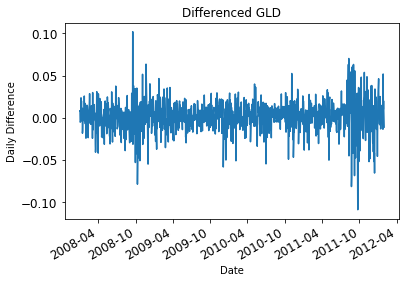

Asset:  XOM
test statistic         -1.184131e+01
p-value                 7.578074e-22
# of lags               8.000000e+00
# of observations       1.019000e+03
Critical Value (1%)    -3.436784e+00
Critical Value (5%)    -2.864381e+00
Critical Value (10%)   -2.568282e+00
dtype: float64 



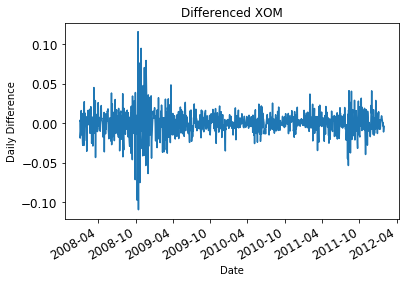

In [10]:
lags = np.array([])
for sym in syms:
    print('Asset: ', sym)
    diff = stationary_df[sym]
    adf_df = adfuller(diff)
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, '\n')
    title = 'Differenced ' + str(sym)
    ax = diff.plot(title=title, fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Difference')
    plt.show()

# If you run this cell, you will see that the series in this portfolio are stationary time series
# since the p-values are much smaller than 0.05, note that all of the critical values are less than the test statistic

The next few cells will focus on setting up an ARIMA model for each column in stationary_df for modelling purposes.

[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) stands for **A**uto**r**egressive **I**ntegrated **M**oving **A**verage.

It is a popular model used for doing time series analysis. 

I'll start off by test it out on one of the columns of stationary_df.

C:\Users\329982789\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\329982789\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.AAPL   No. Observations:                 1027
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2372.878
Method:                       css-mle   S.D. of innovations              0.024
Date:                Mon, 30 Jul 2018   AIC                          -4739.755
Time:                        15:08:11   BIC                          -4724.952
Sample:                             1   HQIC                         -4734.136
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0013      0.001      1.733      0.083      -0.000       0.003
ar.L1.D.AAPL    -0.0066      0.031     -0.211      0.833      -0.068       0.055
                                    Roots   

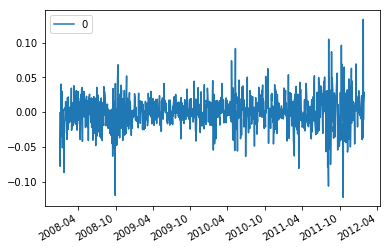

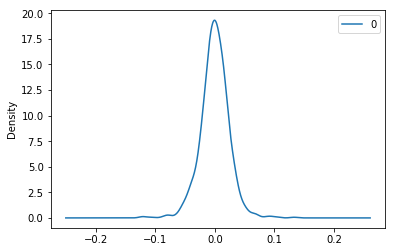

                  0
count  1.027000e+03
mean  -4.164228e-10
std    2.401814e-02
min   -1.224018e-01
25%   -1.303215e-02
50%    4.761758e-04
75%    1.398940e-02
max    1.332003e-01


In [11]:
AAPL = prices_norm['AAPL']
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import kurtosis
model = ARIMA(AAPL, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print('Kurtosis of residuals: ', kurtosis(residuals))
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Some key takeaways from the results above:
The distribution of residuals (difference between observed value and value predicted by model) is centered about zero
and *leptokurtic*. This means that the distribution of residuals  contains far less outliers (which are large errors in this case) than a [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution). This is further corroborated by the fact that the Kurtosis of this distribution is greater than 3.  
Overall, the error after fitting the model with a [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter) should be
very small.

predicted=2.082063, expected=2.110561
predicted=2.111267, expected=2.121901
predicted=2.128221, expected=2.145456
predicted=2.145511, expected=2.167878
predicted=2.171940, expected=2.164476
predicted=2.164376, expected=2.172208
predicted=2.171792, expected=2.168651
predicted=2.170421, expected=2.162724
predicted=2.162344, expected=2.154631
predicted=2.156588, expected=2.179681
predicted=2.182074, expected=2.202361
predicted=2.208286, expected=2.195351
predicted=2.197115, expected=2.157105
predicted=2.155896, expected=2.193598
predicted=2.193360, expected=2.157672
predicted=2.163833, expected=2.292408
predicted=2.289695, expected=2.281996
predicted=2.302937, expected=2.295603
predicted=2.281127, expected=2.324983
Test MSE: 0.001365


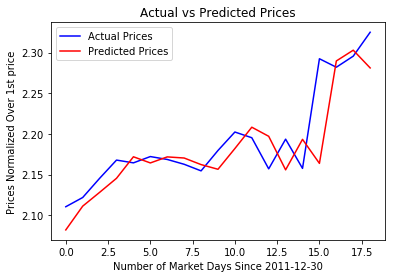

In [12]:
# this cell displays and plots the AAPL prices predicted by the ARIMA model and the actual AAPL prices

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
train = prices_norm['AAPL']['2010-01-01':'2011-12-30']
test = prices_norm['AAPL']['2012-01-01':'2012-01-30']
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    prediction = output[0][0]
    predictions.append(prediction)
    observation = test[t]
    history.append(observation)
    print('predicted=%f, expected=%f' % (prediction, observation))
error = mean_squared_error(test, predictions)
print('Test MSE: %f' % error)
plt.plot(test.tolist(),color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.ylabel('Prices Normalized Over 1st price')
plt.xlabel('Number of Market Days Since 2011-12-30')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()


Test MSE: 0.000519


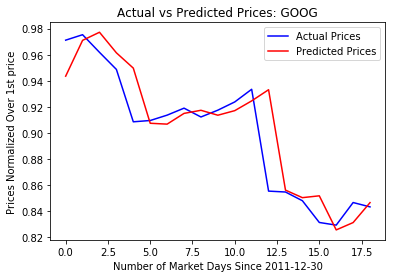

Test MSE: 0.001365


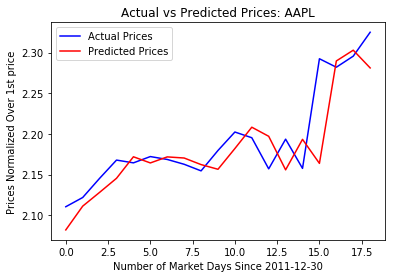

Test MSE: 0.000396


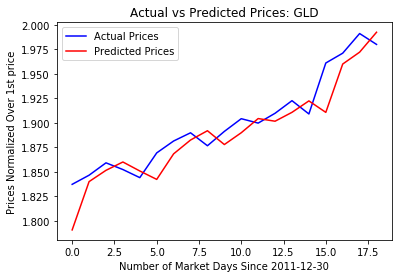

Test MSE: 0.000042


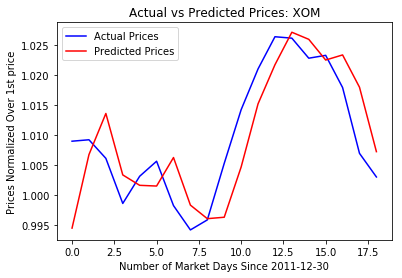

In [13]:
# this cell perform the same actions as the cell above for each stock in the portfolio and store the results in 
# the dataframe predicts. It will also show the mean-squared error (MSE) for each array of predictions
# and their respective observations
predicts = pd.DataFrame()
for sym in syms:
    train = prices_norm[sym]['2010-01-01':'2011-12-30']
    test = prices_norm[sym]['2012-01-01':'2012-01-30']
    history = [x for x in train]
    predictions = list()

    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        prediction = output[0][0]
        predictions.append(prediction)
        observation = test[t]
        history.append(observation)
        #print('predicted=%f, expected=%f' % (prediction, observation))#uncomment the code to the right to see predicted values
                                                                       # and expected values side by side to see for comparison 
    error = mean_squared_error(test, predictions)
    print('Test MSE: %f' % error)
    predicts[sym] = predictions
    plt.plot(test.tolist(),color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.ylabel('Prices Normalized Over 1st price')
    plt.xlabel('Number of Market Days Since 2011-12-30')
    plt.legend()
    plt.title('Actual vs Predicted Prices: ' + sym)
    plt.show()

 Based on the graphs above, while the ARIMA forecasts looks like a good fit with low MSE (mean squared error)
 it looks like the predicted prices could be shifted a few days back for a better fit
 however I'm not sure if "shifting" the predictions for a better fit is good practice for yielding a better model.
 Regardless, with the forecasted prices, the cell below will find the allocation that minimizes the volatility of daily returns
 composed on the stocks used in this notebook or the allocation that maximzes the Sharpe Ratio. 

Now Optimizing to Minimize Volatility
Now Optimizing to Maximize Sharpe Ratio
Optimal Allocation when Minimizing Volatility of Daily Returns:  [0.03310519 0.         0.25551431 0.7113805 ]
Optimal Allocation when Maximizing Sharpe Ratio:  [0.00000000e+00 1.11910481e-13 1.00000000e+00 0.00000000e+00]


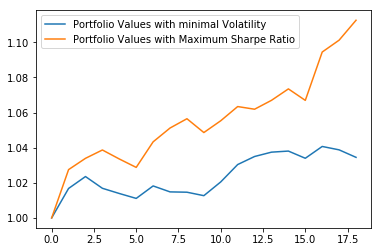

In [14]:
def optimize_portfolio(stock_df,criteria='volatility'):
    # this function takes a DataFrame (stock_df) as input and returns the optimal portfolio allocations
    # the resulting portfolio values based on what criteria you want to optimize on.
    
    rfr = 0.009 # Risk-Free Rate 
    
    def portfolio_vol(alloc, stocks=stock_df):
    #this function returns the standard deviation (Volatility) of the daily returns given the allocation of the portfolio
    # and the data of the assets in the portfolio
    
    
        #get daily portfolio values
        alloc_val = (stocks/stocks.iloc[0])*alloc    
        port_val = alloc_val.sum(1)
        daily_returns = port_val[:-1].values/port_val[1:] - 1 
        return np.std(daily_returns)
    
    def SharpeRatio(alloc,stocks=stock_df):
    # this function returns the negative of the Sharpe Ratio of the portfolio given the allocations and the stock data
        
        alloc_val = (stocks/stocks.iloc[0])*alloc    
        port_val = alloc_val.sum(1)
        cr = port_val.iloc[-1]/port_val.iloc[0]-1
        daily_returns = port_val[:-1].values/port_val[1:] - 1 
        SharpeRatio = (cr - rfr)/np.std(daily_returns)
        
        return -SharpeRatio
    
    # initial guess for the weights
    l = len(syms)
    allocs = np.ones(l)/l
    
    # creating bounds
    bnds = tuple((0., 1.) for _ in range(l))
    
    #constraint for optimization algorithm
    cons = [{'type':'eq', 'fun':lambda allocs: allocs.sum(0) - 1 }]
    
    
    if criteria == 'volatility':
        print("Now Optimizing to Minimize Volatility")
        allocs = opt.minimize(portfolio_vol,allocs,method="SLSQP",bounds=bnds,constraints=cons).x
    elif criteria == 'Sharpe Ratio':
        print("Now Optimizing to Maximize Sharpe Ratio")
        allocs = opt.minimize(SharpeRatio,allocs,method="SLSQP",bounds=bnds,constraints=cons).x
        
    alloc_val = (stock_df/stock_df.iloc[0])*allocs    
    port_val = alloc_val.sum(1)

    return allocs, port_val

alloc, portfolio = optimize_portfolio(predicts)
alloc1, portfolio1 = optimize_portfolio(predicts,criteria='Sharpe Ratio')
print('Optimal Allocation when Minimizing Volatility of Daily Returns: ', alloc)
print('Optimal Allocation when Maximizing Sharpe Ratio: ', alloc1)
port = portfolio.values
port1 = portfolio1.values
portfolios = pd.DataFrame({'Portfolio Values with minimal Volatility': port \
                           , 'Portfolio Values with Maximum Sharpe Ratio': port1})
portfolios.plot()

If you want a portfolio which minimizes the volatility of daily returns, then about 3% of the portfolio should in be GOOG stocks, none should be in AAPL stocks 25% should be in GLD stocks and 71% should be in XOM stocks.

If you want a portfolio which maximizes the Sharpe Ratio of daily_returns, then about 19% of the portfolio should be in GOOG and 81% should be in GLD

Mean Squared Error:  0.0001782372527558892 

Forecasted Cumulative Return:  0.034492710292493456
Actual Cumulative Return:  0.022940242222490914 

Forecasted Volatility:  0.011557807699149051
Actual Volatility:  0.011956340713126245 

Forecasted Sharpe Ratio 2.2056700505901623
Actual Sharpe Ratio 1.1659288202774825


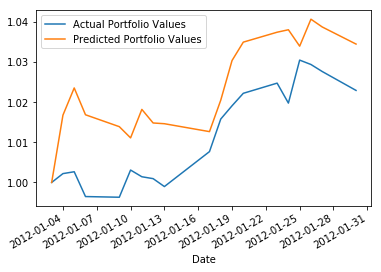

In [15]:
# comparing actual data against forecasted portfolio optimized to for minimal volatility on returns
actual = prices_norm.loc['2012-01-01':'2012-01-30']
actual_port = actual*alloc
actual_portfolio = actual_port.sum(1)
actual_portfolio = actual_portfolio/actual_portfolio[0]
actual_val = actual_portfolio.values
predict_val = portfolio.values
portfolios = pd.DataFrame({'Date':actual_portfolio.index, 'Actual Portfolio Values': actual_val \
                           , 'Predicted Portfolio Values': predict_val })
portfolios = portfolios.set_index('Date')
portfolios.plot()
rfr = 0.009 # Risk-Free Rate
pcm = predict_val[-1]/predict_val[0] - 1 # predicted Cumulative Return
acm = actual_val[-1]/actual_val[0] - 1 # Actual Cumulative Return
pv = np.std(predict_val) # predicted portfolio volatility
av = np.std(actual_val) # actual portfolio volatility
psr = (pcm - rfr)/pv # predicted Sharpe Ratio
asr = (acm - rfr)/av # actual Sharpe Ratio
print('Mean Squared Error: ', mean_squared_error(actual_val, predict_val), '\n')
print('Forecasted Cumulative Return: ', pcm)
print('Actual Cumulative Return: ', acm, '\n')
print('Forecasted Volatility: ', pv)
print('Actual Volatility: ', av, '\n')
print('Forecasted Sharpe Ratio', psr)
print('Actual Sharpe Ratio', asr)






Mean Squared Error:  0.0005654596052323688 

Forecasted Cumulative Return:  0.11256722211481551
Actual Cumulative Return:  0.0776680348896901 

Forecasted Volatility:  0.02673129284822961
Actual Volatility:  0.02497696041210257 

Forecasted Sharpe Ratio 3.874381336616672
Actual Sharpe Ratio 2.7492550637353395


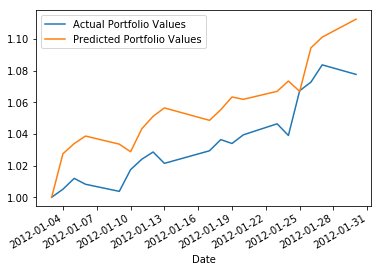

In [16]:
# comparing actual data against forecasted portfolio optimized to for maximum Sharpe Ratio
actual = prices_norm.loc['2012-01-01':'2012-01-30']
actual_port = actual*alloc1
actual_portfolio = actual_port.sum(1)
actual_portfolio = actual_portfolio/actual_portfolio[0]
actual_val = actual_portfolio.values
predict_val = portfolio1.values
portfolios = pd.DataFrame({'Date':actual_portfolio.index, 'Actual Portfolio Values': actual_val \
                           , 'Predicted Portfolio Values': predict_val })
portfolios = portfolios.set_index('Date')
portfolios.plot()
rfr = 0.009 # Risk-Free Rate
pcm = predict_val[-1]/predict_val[0] - 1 # predicted Cumulative Return
acm = actual_val[-1]/actual_val[0] - 1 # Actual Cumulative Return
pv = np.std(predict_val) # predicted portfolio volatility
av = np.std(actual_val) # actual portfolio volatility
psr = (pcm - rfr)/pv # predicted Sharpe Ratio
asr = (acm - rfr)/av # actual Sharpe Ratio
print('Mean Squared Error: ', mean_squared_error(actual_val, predict_val), '\n')
print('Forecasted Cumulative Return: ', pcm)
print('Actual Cumulative Return: ', acm, '\n')
print('Forecasted Volatility: ', pv)
print('Actual Volatility: ', av, '\n')
print('Forecasted Sharpe Ratio', psr)
print('Actual Sharpe Ratio', asr)

# In Conclusion
 
While the mean squared error is very small between the two portfolios, the forecasted cumulative return and 
Sharpe Ratio are much larger in the forecasts than in acutality.


In the end, when predicting stock prices and volatility, perhaps rely on **more** than just a time-series model.